# Кредитный скоринг юридических лиц

## Задача: Разработать модель кредитного скоринга юридического лица. Модель должна позволить определить, следует ли выдавать кредит юридическому лицу по заданным признакам

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pathlib
import os
import gc

%matplotlib inline
sns.set()

warnings.filterwarnings("ignore")

## Этап 1: Импорт данных

In [2]:
print(*[f'Список файлов в репозитории {x.split("/")[-1]}: {sorted(os.listdir(x), key=lambda x: len(x))}' for x in ["./train", "./test"]], sep='\n')

Список файлов в репозитории train: ['train_1.csv', 'train_2.csv', 'train_3.csv', 'train_4.csv', 'train_5.csv', 'train_6.csv', 'train_7.csv', 'train_8.csv', 'train_9.csv', 'train_10.csv', '.ipynb_checkpoints']
Список файлов в репозитории test: ['test_1.csv', 'test_2.csv', 'test_3.csv', 'test_4.csv', 'test_5.csv', 'test_6.csv', 'test_7.csv', 'test_8.csv', 'test_9.csv', 'test_10.csv']


In [3]:
# Получим список путей к файлам в папке train
filenames_train = [x for x in sorted(os.listdir("./train"), key=lambda x: len(x)) if x.endswith(".csv")]

# Создадим список для записи считанных файлов train
data_files_train = []

# Считаем все файлы train и добавим их в список
for filename in filenames_train:
    # print(pathlib.Path.cwd().joinpath("./train", filename))
    data_files_train.append(pd.read_csv(pathlib.Path.cwd().joinpath("./train", filename)))

train_df = pd.concat(data_files_train, ignore_index=True)

print('Размерность полных тренировочных данных составляет: {} строка и {} столбец'.format(*train_df.shape))

Размерность полных тренировочных данных составляет: 38731 строка и 421 столбец


In [4]:
# Получим список путей к файлам в папке test
filenames_test = [x for x in sorted(os.listdir("./test"), key=lambda x: len(x)) if x.endswith(".csv")]

# Создадим список для записи считанных файлов test
data_files_test = []

# Считаем все файлы test и добавим их в список
for filename in filenames_test:
    # print(pathlib.Path.cwd().joinpath("./test", filename))
    data_files_test.append(pd.read_csv(pathlib.Path.cwd().joinpath("./test", filename)))

test_df = pd.concat(data_files_test, ignore_index=True)

print('Размерность полных тренировочных данных составляет: {} строка и {} столбец'.format(*test_df.shape))

Размерность полных тренировочных данных составляет: 19826 строка и 420 столбец


In [5]:
FEATURE_COLUMNS = train_df.drop(columns=["target", "smpl", "id"]).columns

## Этап 2: Обзор набора данных

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38731 entries, 0 to 38730
Columns: 421 entries, target to feature_418
dtypes: float64(418), int64(2), object(1)
memory usage: 124.4+ MB


In [7]:
train_df.describe()

,target,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
count,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,...,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000,38731.000000
mean,0.021766,19365.000000,-0.011868,-0.022720,0.240066,0.014769,0.002543,-0.121256,-0.021874,-0.212568,...,0.007855,-0.289571,0.046371,-0.011372,-0.045371,-0.009627,0.010300,-0.019660,-0.007003,-0.026602
std,0.145919,11180.820975,0.992397,0.991483,0.427129,1.006943,1.008098,0.983779,0.979137,0.935391,...,0.994804,0.806576,0.250005,0.998106,0.978557,0.972842,1.006719,0.990136,1.004295,0.987498
min,0.000000,0.000000,-5.199338,-5.199338,0.000000,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-3.232688,-5.199338,0.000000,-5.199338,-5.199338,-5.199338,-5.199338,-3.408886,-5.199338,-5.199338
25%,0.000000,9682.500000,-0.681368,-0.693879,0.000000,-0.667434,-0.684292,-0.777239,-0.671211,-0.833827,...,-0.671584,-0.816589,0.000000,-0.694098,-0.700684,-0.676811,-0.676359,-0.687918,-0.678918,-0.692241
50%,0.000000,19365.000000,-0.014384,-0.014327,0.000000,0.025820,0.005269,-0.166902,-0.021997,-0.207170,...,0.017161,-0.216972,0.000000,-0.016165,-0.035410,-0.000174,0.020541,-0.018817,-0.012701,-0.030068
75%,0.000000,29047.500000,0.658456,0.651838,0.000000,0.706342,0.682534,0.566233,0.637608,0.407831,...,0.681021,0.320220,0.000000,0.667831,0.629747,0.645590,0.694864,0.655448,0.666673,0.657315
max,1.000000,38730.000000,5.199338,5.199338,1.000000,5.199338,5.199338,2.722168,5.199338,5.199338,...,5.199338,1.395742,2.000000,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,3.585167


In [8]:
print('Отсутствующие значения в наборе данных поездов:', sum(train_df.isnull().sum()))
print('Отсутствующие значения в наборе данных поездов:', sum(test_df.isnull().sum()))

Отсутствующие значения в наборе данных поездов: 0
Отсутствующие значения в наборе данных поездов: 0


## Этап 3: Обзор признаков

### Распределение таргетов

<Axes: xlabel='target', ylabel='count'>

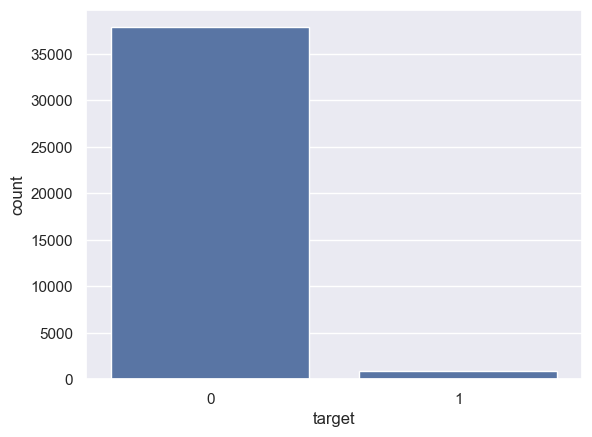

In [9]:
sns.countplot(data=train_df, x="target")

Таргеты распределены неравномерно

In [10]:
train_df["target"].value_counts()

target
0    37888
1      843
Name: count, dtype: int64

### Корреляция признаков с таргетом

Количество прзнаков: 122


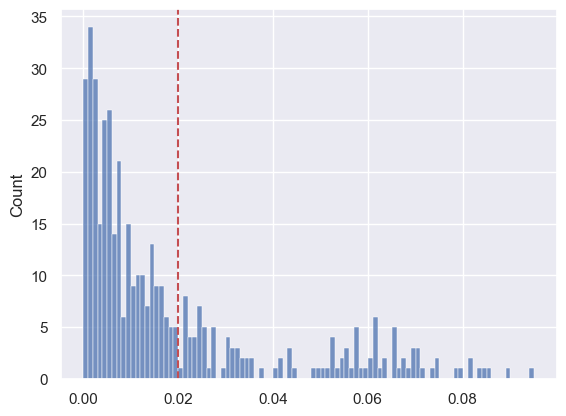

In [11]:
corr_target = [(col, round(abs(float(np.corrcoef(train_df['target'], train_df[col])[0][1])), 4)) for col in FEATURE_COLUMNS]
sns.histplot([x[1] for x in corr_target], binwidth=0.001)
plt.axvline(x=0.02, color="r", linestyle="--")

# На основе визуального анализа получим из выборки все признаки с корреляцией от 0.02
FEATURE_COLUMNS_TARGET_CORR = [x[0] for x in corr_target if x[1] >= 0.02]
print(f"Количество прзнаков: {len(FEATURE_COLUMNS_TARGET_CORR)}")

### Корреляция между признаками

In [12]:
# Получим матрицу корреляций
corr_matrix = train_df[FEATURE_COLUMNS_TARGET_CORR].corr()

In [13]:
# Создадим список пар признаков и их корреляций и отсортируем его по убыванию
# Получим все значения где показатель корреляции превышает порог:
threshold = .9

corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = abs(corr_matrix.iloc[i, j])
        if corr_value >= threshold:
            corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))
            
corr = np.array(sorted(corr, key=lambda x: x[2], reverse=True))

In [14]:
from scipy.stats import pearsonr

# Получим список самых коррелирующих признаков. Оставляем значения с меньшим p-value
most_corr_features = []

for f_1, f_2, _ in corr:
    if f_1 in most_corr_features or f_2 in most_corr_features:        
        continue
    else:
        if pearsonr(train_df[f_1], train_df["target"])[1] > pearsonr(train_df[f_2], train_df["target"])[1]:
            most_corr_features.append(f_1)
        else:
            most_corr_features.append(f_2)
            
print(f"Количество признаков: {len(most_corr_features)}")    
print(*most_corr_features)

Количество признаков: 8
feature_101 feature_17 feature_372 feature_3 feature_358 feature_341 feature_366 feature_135


## Этап 4: Отбор признаков

In [15]:
# Возьмем признаки с высокой корреляцией с таргетом и удалим из них самые коррелирующие между собой признаки
FEATURE_COLUMNS_WITHOUT_CORR = list(set(FEATURE_COLUMNS_TARGET_CORR) - set(most_corr_features))
print(f"Количество признаков: {len(FEATURE_COLUMNS_WITHOUT_CORR)}")  

Количество признаков: 114


#### Метод SelectKBest

In [16]:
from sklearn.feature_selection import f_classif, RFECV, SelectKBest, mutual_info_classif

In [17]:
selector = SelectKBest(mutual_info_classif, k=20)
selector.fit(train_df[FEATURE_COLUMNS_WITHOUT_CORR], train_df["target"])
BEST_FEATURES_SKB = selector.get_feature_names_out()

#### Метод RFECV

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [19]:
min_features_to_select = 10
clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=7,
    cv=cv,
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

rfecv.fit(train_df[FEATURE_COLUMNS_WITHOUT_CORR], train_df["target"])
BEST_FEATURES_RFECV = rfecv.get_feature_names_out()
print(f"Количество прзнаков по RFECV: {len(BEST_FEATURES_RFECV)}")

Количество прзнаков по RFECV: 23


## Этап 5: Подготовка данных

#### Аугментирование данных

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PipeImb

In [21]:
features = train_df[BEST_FEATURES_RFECV]
target = train_df["target"]

print(f"Всего до баланса сэмплов: {len(target)}")
print(f"Распред. классов до баланса: {np.bincount(target)}\n")

processing_data = PipeImb([
    ("smote", SMOTE(sampling_strategy=0.1, random_state=42)),
    ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=42))
])

f, t = processing_data.fit_resample(features, target)

print(f"Всего после баланса сэмплов: {len(t)}")
print(f"Распред. классов после баланса: {np.bincount(t)}")

Всего до баланса сэмплов: 38731
Распред. классов до баланса: [37888   843]

Всего после баланса сэмплов: 11364
Распред. классов после баланса: [7576 3788]


#### Scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [23]:
scaler = StandardScaler()

f = scaler.fit_transform(f)

#### Веса классов в датасете

In [24]:
from sklearn.utils.class_weight import compute_class_weight

In [25]:
class_weight = compute_class_weight("balanced", classes=np.unique(t), y=t)
class_weight_dict = dict(enumerate(class_weight))
print(f"Веса классов: {class_weight_dict}")

Веса классов: {0: 0.75, 1: 1.5}


#### Разбиение данных на Train и Test

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(f, t, test_size=0.2, random_state=42, stratify=t)

## Этап 6: Объявление модели и подбор гиперпараметров

# CatBoost

In [28]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

### Поиск гиперпараметров

In [ ]:
model = CatBoostClassifier()

grid_param = {
    "early_stopping_rounds": [15, 60],
    "iterations": [1500, 600, 1000],
    "learning_rate": [0.001],
    "max_depth": [3, 7, 10],
    "l2_leaf_reg": [9, 7, 2],
    "bagging_temperature": [1, 1.5],
    "class_weights": [class_weight_dict]
}

grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=grid_param,
    cv=3,
    return_train_score=True,
    scoring='roc_auc',
)

grid_search.fit(f, t).best_params_

### Обучение модели

In [32]:
model = CatBoostClassifier(
    iterations=6000,
    learning_rate=0.001,
    depth=6,
    loss_function="Logloss",
    eval_metric="Logloss",
    custom_metric=["AUC"],
    early_stopping_rounds=30,
    random_seed=42,
    l2_leaf_reg=1,
    bagging_temperature=2,
    class_weights=class_weight_dict,

).fit(
    X=X_train,
    y=y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True,
    use_best_model=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Визуализация обучения

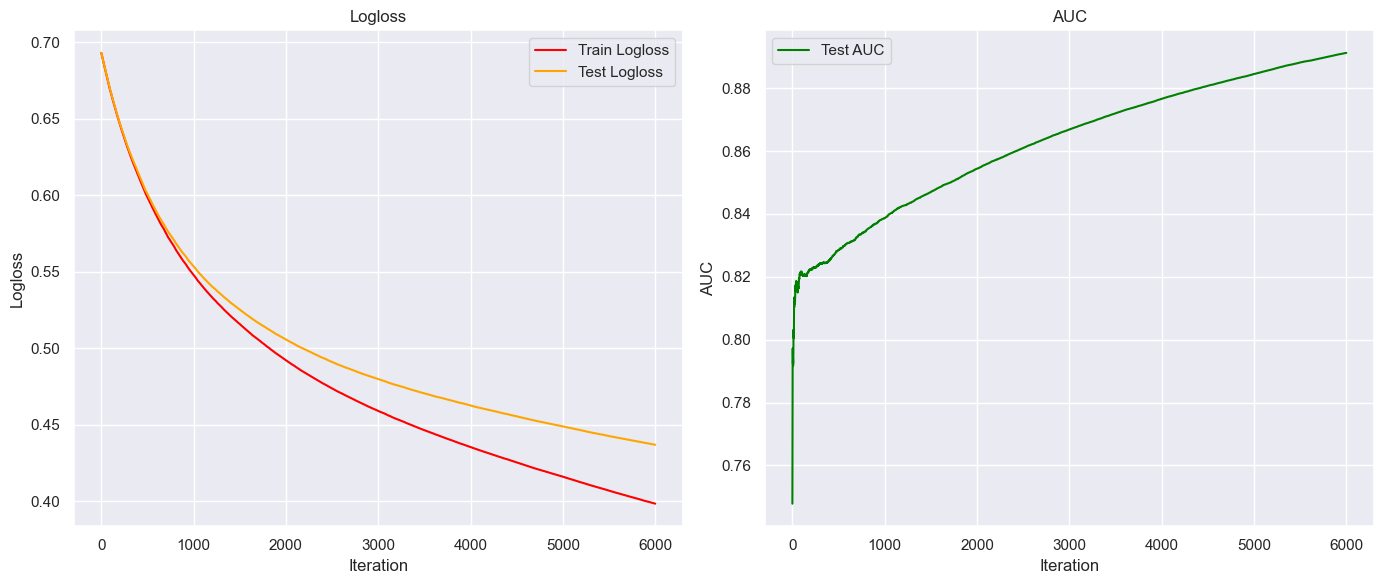

In [41]:
metrics_train = model.get_evals_result()["learn"]
metrics_test = model.get_evals_result()["validation"]

metrics = pd.DataFrame({
    "Iteration": range(len(train_metrics["Logloss"])),
    "Train Logloss": train_metrics["Logloss"],
    "Test Logloss": test_metrics["Logloss"],
    "Test AUC": test_metrics["AUC"]
})

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=metrics, x="Iteration", y="Train Logloss", label="Train Logloss", color="red")
sns.lineplot(data=metrics, x="Iteration", y="Test Logloss", label="Test Logloss", color="orange")
plt.title("Logloss")
plt.xlabel("Iteration")
plt.ylabel("Logloss")
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(data=metrics, x="Iteration", y="Test AUC", label="Test AUC", color="green")
plt.title("AUC")
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()